In [21]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm

from transport_problem import DualOracle, OptimParams
from acrcd_no_adaptive import ACRCDOracleStacker, ACRCD_star
import numpy as np

from transport_problem import HyperParams, OptimParams
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types
from get_graph import get_graph_by_name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
net_df, corrs = get_graph_by_name("SiouxFalls")

graph type:  SiouxFalls


In [16]:
graph = gt.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

l = np.maximum(np.sum(corrs, axis=1), 1e-6)
w = np.maximum(np.sum(corrs, axis=0), 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)

In [17]:
def test_transport_problem(graph, net_df, l, w, params, sources, targets):
    dual_oracle = DualOracle(
        graph, l, w, params
    )
    oracle_stacker = ACRCDOracleStacker(
        dual_oracle,
        graph,
        sources,
        targets
    )
    
    return ACRCD_star(oracle_stacker, *oracle_stacker.get_init_vars_block(), 1000)

In [18]:
results = test_transport_problem(graph,net_df, l, w, params, sources, targets)


100%|██████████| 1000/1000 [00:01<00:00, 648.87it/s]


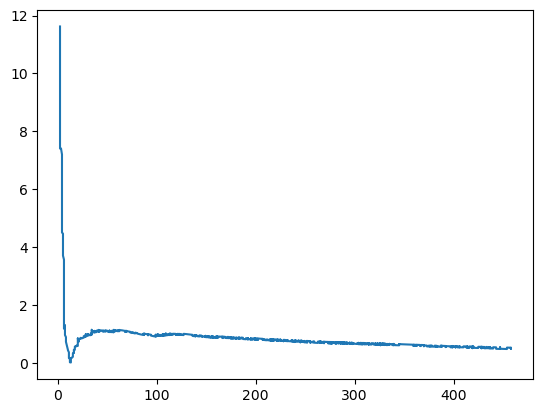

In [22]:
plt.plot(results.history_la_mu_calls, results.history_dual_gap)

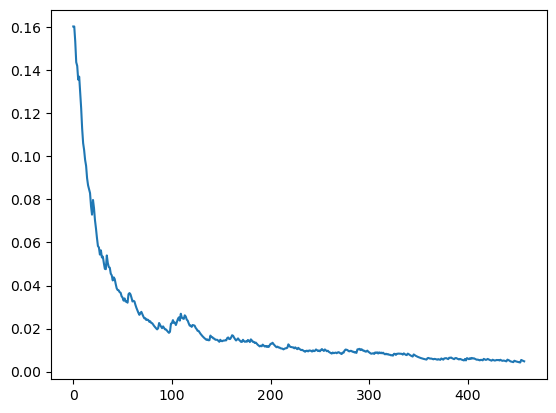

In [23]:
plt.plot(results.history_la_mu_grad_norm)

In [ ]:
plt.yscale('log')
plt.plot(history, label="dgap")

In [ ]:
import pandas as pd

data = []
x = t_calls
for i, j, k in zip(x, np.abs(history[1:]), np.abs(la_mu_grad_norms)):
    data.append((i, j, k))

df = pd.DataFrame(data)
df.to_csv("plot_ustm.csv", index=False)

In [ ]:
plt.yscale('log')
plt.plot(la_mu_grad_norms)

In [ ]:
x = t_calls
dual_gap = history
dual_gap_clipped = np.maximum(0, dual_gap)
                                
metric = 2 * np.array(results.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
plt.plot(x, metric, label="custom metric")
plt.yscale("log")
plt.legend()
plt.show()